## General information

In this kernel I'm working with data from Google Cloud & NCAA® ML Competition 2019-Men's Challenge. We'll try to predict winners of NCAA based on previous tournaments! We have a lot of data, so let's start with EDA.

![](https://www.ncaa.com/sites/default/files/public/styles/large/public-s3/images/2018-11-06/2019-NCAA-bracket-March-Madness-tournament-PDF.png?itok=etptsRdC)

Work in progress.


In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import os
import glob

## Data overview and loading

We have a lof of files and data. Let's have a look at them!

In [2]:
print(os.listdir('../input/'))
print(os.listdir('../input/datafiles'))

['playbyplay_2016', 'masseyordinals', 'playbyplay_2011', 'SampleSubmissionStage1.csv', 'playbyplay_2018', 'datafiles', 'playbyplay_2017', 'playbyplay_2014', 'playbyplay_2012', 'playbyplay_2010', 'playbyplay_2015', 'playbyplay_2013']
['ConferenceTourneyGames.csv', 'Conferences.csv', 'NCAATourneySlots.csv', 'Cities.csv', 'NCAATourneySeeds.csv', 'TeamConferences.csv', 'Teams.csv', 'RegularSeasonCompactResults.csv', 'GameCities.csv', 'NCAATourneyDetailedResults.csv', 'Seasons.csv', 'TeamCoaches.csv', 'RegularSeasonDetailedResults.csv', 'SecondaryTourneyTeams.csv', 'SecondaryTourneyCompactResults.csv', 'NCAATourneyCompactResults.csv', 'NCAATourneySeedRoundSlots.csv', 'TeamSpellings.csv']


We have a folder `datafiles` with main data, we have playbyplay info (play-by-play event logs) and masseyordinals (various rankings over years).

In the submission we must predict probabilities of victory for all pairs of teams.

In [3]:
masseyordinals = pd.read_csv('../input/masseyordinals/MasseyOrdinals.csv')
sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
sub.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


Notice that submission has data since 2014 year.

Let's read all files in `datafiles` into one dictionary for convenience.

In [4]:
data_dict = {}
for i in glob.glob('../input/datafiles/*'):
    name = i.split('/')[-1].split('.')[0]
    print(i)
    if name != 'TeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='latin-1')        

../input/datafiles/ConferenceTourneyGames.csv
../input/datafiles/Conferences.csv
../input/datafiles/NCAATourneySlots.csv
../input/datafiles/Cities.csv
../input/datafiles/NCAATourneySeeds.csv
../input/datafiles/TeamConferences.csv
../input/datafiles/Teams.csv
../input/datafiles/RegularSeasonCompactResults.csv
../input/datafiles/GameCities.csv
../input/datafiles/NCAATourneyDetailedResults.csv
../input/datafiles/Seasons.csv
../input/datafiles/TeamCoaches.csv
../input/datafiles/RegularSeasonDetailedResults.csv
../input/datafiles/SecondaryTourneyTeams.csv
../input/datafiles/SecondaryTourneyCompactResults.csv
../input/datafiles/NCAATourneyCompactResults.csv
../input/datafiles/NCAATourneySeedRoundSlots.csv
../input/datafiles/TeamSpellings.csv


In [5]:
data_dict['Teams'].head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2019
1,1102,Air Force,1985,2019
2,1103,Akron,1985,2019
3,1104,Alabama,1985,2019
4,1105,Alabama A&M,2000,2019


In `Teams` we have info on first and last season of each team.

In [6]:
data_dict['TeamSpellings'].head()

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene-christian,1101


In `TeamSpellings` we have info about all spellings of all teams. Let's use this as a feature!

In [7]:
team_counts = data_dict['TeamSpellings'].groupby('TeamID')['TeamNameSpelling'].count().reset_index()
team_counts.columns = ['TeamID', 'TeamSpellingCount']

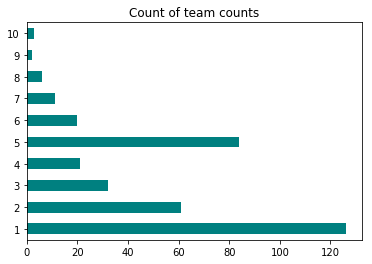

In [8]:
plt.title('Count of team counts');
team_counts['TeamSpellingCount'].value_counts().sort_index().plot(kind='barh', color='teal');

## Creating training data

At first we need to create some training data. We need to predict the results of matches between teams. So the data should have season (year), two teams and the result. Features should be based on teams or on teams and season.
Also we need to remember that we will need to predict the performance of teams before the beginning of the tournament, so we won't have information on teams performance in that tournament and need to use previously available information.

In stage 1 we need to make predictions for certain matches since 2014 year. To prevent leaks I'll use the data up to 2013 for training.

Let's use NCAATourneySeeds data as a blueprint!

In [9]:
data_dict['NCAATourneySeeds'].head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Seed is very important for determining which team is better, so we will use it as a feature. Let's convert it into number and rearrange the columns.

In [10]:
data_dict['NCAATourneySeeds']['Seed'] = data_dict['NCAATourneySeeds']['Seed'].apply(lambda x: int(x[1:3]))
data_dict['NCAATourneySeeds'] = data_dict['NCAATourneySeeds'][['Season', 'TeamID', 'Seed']]
data_dict['NCAATourneySeeds'].head()

,Season,TeamID,Seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


We also have information about the results of season matches.

In [11]:
data_dict['NCAATourneyCompactResults'] = data_dict['NCAATourneyCompactResults'][['Season','WTeamID', 'LTeamID']]
data_dict['NCAATourneyCompactResults'].head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


We can create a new dataframe which will have info about matches and seeds of teams

In [12]:
df = pd.merge(data_dict['NCAATourneyCompactResults'], data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
df['seed_diff'] = df['Seed_x'] - df['Seed_y']
df.head()

,Season,WTeamID,LTeamID,Seed_x,Seed_y,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


### Regular season results

Let's try using some info from regular seasons

In [13]:
data_dict['RegularSeasonCompactResults'].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


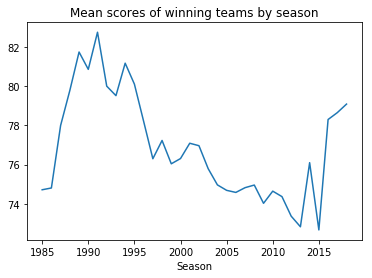

In [14]:
plt.title('Mean scores of winning teams by season');
data_dict['RegularSeasonCompactResults'].groupby(['Season'])['WScore'].mean().plot();

We can see that mean scores peaked in ~1900 and steadily decreased since that time, but in recent years mean scores rise again. Sadly, I don't know enough info about history of matches in NCAA, so I don't have an explanation for such a phenomenon.

I think that using scores in current season as a feature can be considered a leak, so let's add `1` to a year - this way we'll get scores of previous year while merging.

In [15]:
data_dict['RegularSeasonCompactResults']['Season'] += 1

Let's try using mean scores of teams!

In [16]:
team_win_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'WTeamID'])['WScore'].mean().reset_index()
team_loss_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'LTeamID'])['LScore'].mean().reset_index()
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'LTeamID_x'], right_on=['Season', 'WTeamID'])
df.drop(['LTeamID_y', 'WTeamID_y'], axis=1, inplace=True)
df = df.loc[(df['Season'] > 1985) & (df['Season'] < 2014)]
df.head()

,Season,WTeamID_x,LTeamID_x,Seed_x,Seed_y,seed_diff,WScore_x,LScore_x,LScore_y,WScore_y
63,1986,1133,1431,7,10,-3,72.687500,66.555556,67.166667,76.750000
64,1986,1177,1438,12,5,7,74.444444,57.533333,66.111111,63.615385
65,1986,1181,1290,1,16,-15,81.500000,76.727273,72.142857,81.363636
66,1986,1207,1403,4,13,-9,76.680000,58.285714,64.000000,72.545455
67,1986,1210,1265,2,15,-13,73.083333,59.500000,63.428571,64.937500


## Regular seasons detailed results

In [17]:
data_dict['RegularSeasonDetailedResults'].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [18]:
data_dict['RegularSeasonDetailedResults']['Season_join'] = data_dict['RegularSeasonDetailedResults']['Season'] + 1

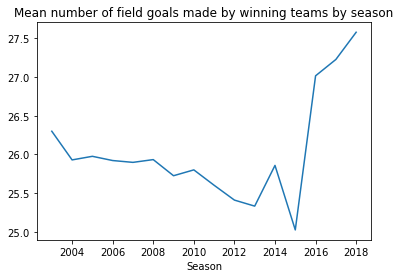

In [19]:
plt.title('Mean number of field goals made by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFGM'].mean().plot();

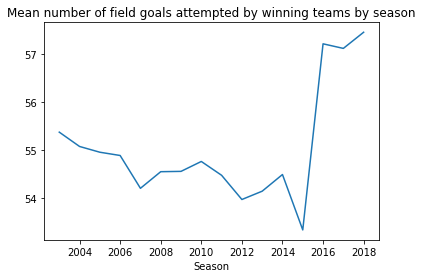

In [20]:
plt.title('Mean number of field goals attempted by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFGA'].mean().plot();

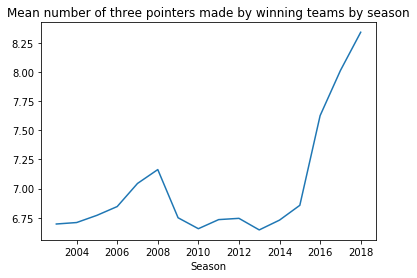

In [21]:
plt.title('Mean number of three pointers made by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFGM3'].mean().plot();

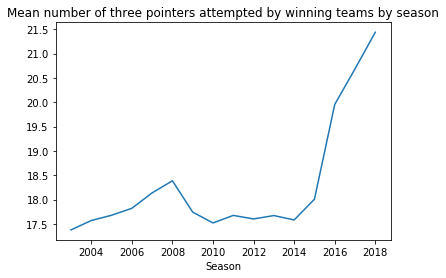

In [22]:
plt.title('Mean number of three pointers attempted by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFGA3'].mean().plot();

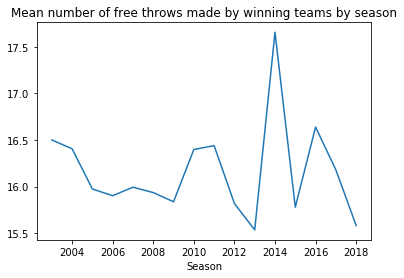

In [23]:
plt.title('Mean number of free throws made by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFTM'].mean().plot();

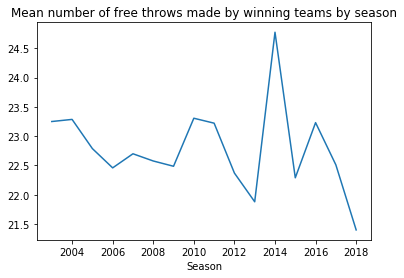

In [24]:
plt.title('Mean number of free throws made by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WFTA'].mean().plot();

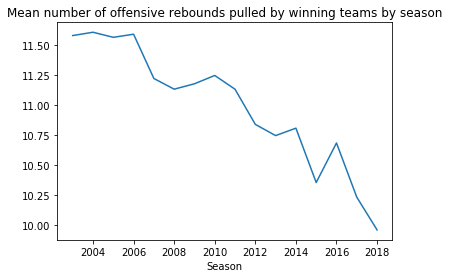

In [25]:
plt.title('Mean number of offensive rebounds pulled by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WOR'].mean().plot();

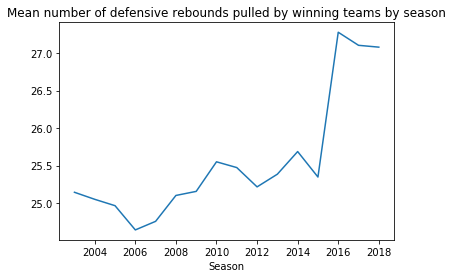

In [26]:
plt.title('Mean number of defensive rebounds pulled by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WDR'].mean().plot();

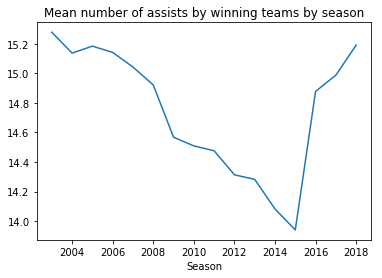

In [27]:
plt.title('Mean number of assists by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WAst'].mean().plot();

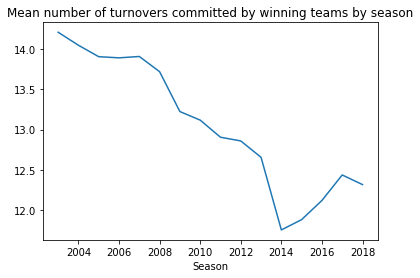

In [28]:
plt.title('Mean number of turnovers committed by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WTO'].mean().plot();

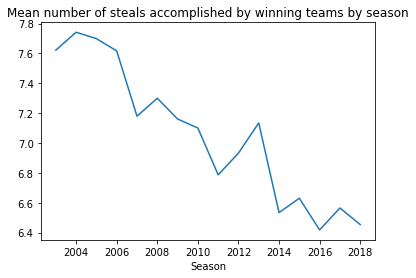

In [29]:
plt.title('Mean number of steals accomplished by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WStl'].mean().plot();

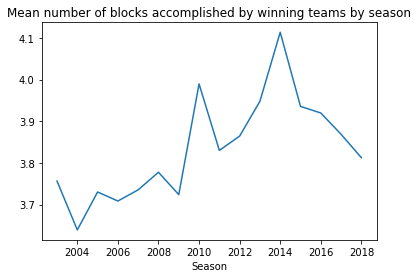

In [30]:
plt.title('Mean number of blocks accomplished by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WBlk'].mean().plot();

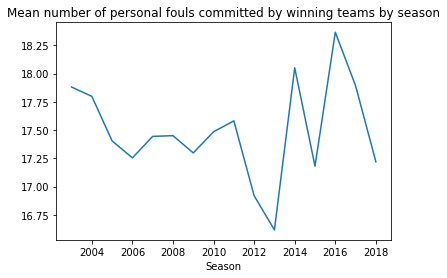

In [31]:
plt.title('Mean number of personal fouls committed by winning teams by season');
data_dict['RegularSeasonDetailedResults'].groupby(['Season'])['WPF'].mean().plot();

### Target variable

**Important**

The idea is the following: currently we have pairs of teams and we know which of them is loser, which is winner. For predictions we have pairs of teams, where we won't know who is winner, but we know that the teams will be sorted (like 1214_1246 and not the other way). So we can modify the training dataframe in the following way:
- create columns not for winning/losing team, but for teams with lower and higher number;
- of team with lower number of the winner, the target is 1 and 0 otherwise.

In [32]:
df.head()

,Season,WTeamID_x,LTeamID_x,Seed_x,Seed_y,seed_diff,WScore_x,LScore_x,LScore_y,WScore_y
63,1986,1133,1431,7,10,-3,72.687500,66.555556,67.166667,76.750000
64,1986,1177,1438,12,5,7,74.444444,57.533333,66.111111,63.615385
65,1986,1181,1290,1,16,-15,81.500000,76.727273,72.142857,81.363636
66,1986,1207,1403,4,13,-9,76.680000,58.285714,64.000000,72.545455
67,1986,1210,1265,2,15,-13,73.083333,59.500000,63.428571,64.937500


In [33]:
loss_df = df[df['WTeamID_x'] > df['LTeamID_x']]
win_df = df[df['WTeamID_x'] < df['LTeamID_x']]
win_df['target'] = 1
win_df.columns = ['Season', 'Team1', 'Team2', 'Seed_1', 'Seed_2', 'seed_diff',
       'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'target']
loss_df['target'] = 0
loss_df = loss_df[['Season', 'LTeamID_x', 'WTeamID_x', 'Seed_y', 'Seed_x', 'seed_diff',
       'LScore_y', 'WScore_y', 'WScore_x', 'LScore_x', 'target']]
loss_df.columns = ['Season', 'Team1', 'Team2', 'Seed_1', 'Seed_2', 'seed_diff',
       'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'target']
loss_df['seed_diff'] = -1 * loss_df['seed_diff']
new_df = win_df.append(loss_df)

In [34]:
new_df.head()

,Season,Team1,Team2,Seed_1,Seed_2,seed_diff,WScore_1,LScore_1,LScore_2,WScore_2,target
63,1986,1133,1431,7,10,-3,72.687500,66.555556,67.166667,76.750000,1
64,1986,1177,1438,12,5,7,74.444444,57.533333,66.111111,63.615385,1
65,1986,1181,1290,1,16,-15,81.500000,76.727273,72.142857,81.363636,1
66,1986,1207,1403,4,13,-9,76.680000,58.285714,64.000000,72.545455,1
67,1986,1210,1265,2,15,-13,73.083333,59.500000,63.428571,64.937500,1


## Preparing test data

In [35]:
test = sub.copy()
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub['Team1'] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub['Team2'] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub = pd.merge(sub, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
sub = pd.merge(sub, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'])
sub = pd.merge(sub, team_win_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
sub = pd.merge(sub, team_loss_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
sub = pd.merge(sub, team_loss_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'LTeamID'])
sub = pd.merge(sub, team_win_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'WTeamID'])
sub['seed_diff'] = sub['Seed_x'] - sub['Seed_y']
sub.head()

,ID,Pred,Season,Team1,Team2,TeamID_x,Seed_x,TeamID_y,Seed_y,WTeamID_x,WScore_x,LTeamID_x,LScore_x,LTeamID_y,LScore_y,WTeamID_y,WScore_y,seed_diff
0,2014_1107_1110,0.5,2014,1107,1110,1107,16,1110,15,1107,66.708333,1110.0,53.450000,1107.0,58.9,1110,66.600000,1
1,2014_1107_1112,0.5,2014,1107,1112,1107,16,1112,1,1107,66.708333,1112.0,68.142857,1107.0,58.9,1112,74.720000,15
2,2014_1107_1113,0.5,2014,1107,1113,1107,16,1113,10,1107,66.708333,1113.0,65.083333,1107.0,58.9,1113,74.380952,6
3,2014_1107_1124,0.5,2014,1107,1124,1107,16,1124,6,1107,66.708333,1124.0,67.785714,1107.0,58.9,1124,77.941176,10
4,2014_1107_1140,0.5,2014,1107,1140,1107,16,1140,10,1107,66.708333,1140.0,67.454545,1107.0,58.9,1140,80.550000,6


## Preparing data for training

In [36]:
new_df = pd.merge(new_df, team_counts, how='left', left_on='Team1', right_on='TeamID')
new_df = new_df.drop(['TeamID'], axis=1)
new_df = pd.merge(new_df, team_counts, how='left', left_on='Team2', right_on='TeamID')
new_df = new_df.drop(['TeamID'], axis=1)

sub = pd.merge(sub, team_counts, how='left', left_on='Team1', right_on='TeamID')
sub = sub.drop(['TeamID'], axis=1)
sub = pd.merge(sub, team_counts, how='left', left_on='Team2', right_on='TeamID')
sub = sub.drop(['TeamID'], axis=1)

new_df = new_df.drop(['Season', 'Team1', 'Team2'], axis=1)
sub = sub.drop(['Pred', 'Season', 'Team1', 'Team2', 'TeamID_x', 'TeamID_y', 'WTeamID_x', 'WTeamID_y', 'LTeamID_x', 'LTeamID_y'], axis=1)
sub.columns = ['ID', 'Seed_1', 'Seed_2', 'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'seed_diff', 'TeamSpellingCount_x', 'TeamSpellingCount_y']
sub = sub[['ID', 'Seed_1', 'Seed_2', 'seed_diff', 'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'TeamSpellingCount_x', 'TeamSpellingCount_y']]
new_df = new_df.fillna(0)
sub = sub.fillna(0)

In [37]:
X = new_df.drop(['target'], axis=1)
y = new_df['target']
X_test = sub.drop(['ID'], axis=1)

In [38]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [39]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y.values[train_index], y.values[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)[:, 1].reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.1, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(log_loss(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [40]:
X1 = X.copy()
X_test1 = X_test.copy()

Scaling is necessary for linear models!

In [41]:
scaler = StandardScaler()
X1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']] = scaler.fit_transform(X1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']])
X_test1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']] = scaler.transform(X_test1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']])

In [42]:
%%time
model = linear_model.LogisticRegression(C=0.0001)
oof_lr, prediction_lr, scores = train_model(X1, X_test1, y, params=None, folds=folds, model_type='sklearn', model=model)

Fold 0 started at Tue Feb 19 06:26:14 2019
Fold 1 started at Tue Feb 19 06:26:14 2019
Fold 2 started at Tue Feb 19 06:26:14 2019
Fold 3 started at Tue Feb 19 06:26:14 2019
Fold 4 started at Tue Feb 19 06:26:14 2019
CV mean score: 0.5277, std: 0.0184.
CPU times: user 68 ms, sys: 92 ms, total: 160 ms
Wall time: 49.3 ms


Fold 0 started at Tue Feb 19 06:26:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.0439102	valid_1's binary_logloss: 0.0402531
Fold 1 started at Tue Feb 19 06:26:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.0418671	valid_1's binary_logloss: 0.0533256
Fold 2 started at Tue Feb 19 06:26:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.0430793	valid_1's binary_logloss: 0.0515054
Fold 3 started at Tue Feb 19 06:26:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0440307	valid_1's binary_logloss: 0.0458865
Fold 4 started at Tue Feb 19 06:26:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping

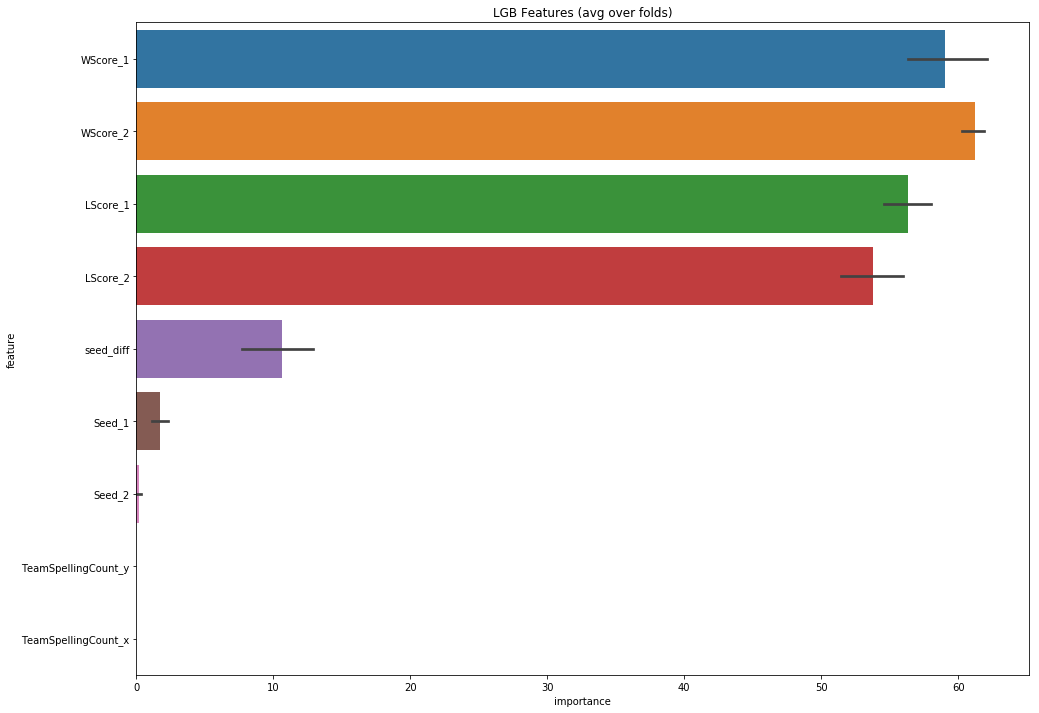

In [43]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [44]:
test['Pred'] = prediction_lr
test.to_csv('submission.csv', index=False)

In [45]:
test['Pred'] = prediction_lgb
test.to_csv('lgb.csv', index=False)